In [1]:
import torch
from torch import nn
from torchvision.datasets import MNIST
from torchvision import transforms, datasets
from torch import optim
import helper
MNIST.resources = [
    ('https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz', 'f68b3c2dcbeaaa9fbdd348bbdeb94873'),
    ('https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz', 'd53e105ee54ea40749a09fcbcd1e9432'),
    ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz', '9fb629c4189551a2d022fa330f9573f3'),
    ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz', 'ec29112dd5afa0611ce80d1b7f02629c')
]


# Download and load the training data
trainset =  datasets.MNIST(root='./data',train=True, transform=transforms.ToTensor(),download=True)       ###download trainset
testset =   datasets.MNIST(root='./data',train=False, transform=transforms.ToTensor(),download=True)            ###download testset
trainloader = torch.utils.data.DataLoader(trainset,batch_size=64,shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=64,shuffle=True)

image, labels = next(iter(trainloader))
print("dimension of first batch of trainloader:", image.shape)

dimension of first batch of trainloader: torch.Size([64, 1, 28, 28])


In [2]:
torch.manual_seed(999)
input_size = 784
hidden_sizes = [256,128, 64]
output_size = 10

# Build a feed-forward network
def build_model(input_size, hidden_sizes, output_size):
    ####Start code here
    model=nn.Sequential(
        nn.Linear(input_size,hidden_sizes[0]),
        nn.ReLU(),
        nn.Linear(hidden_sizes[0],hidden_sizes[1]),
        nn.ReLU(),
        nn.Linear(hidden_sizes[1],hidden_sizes[2]),
        nn.ReLU(),
        nn.Linear(hidden_sizes[2],output_size),
        nn.LogSoftmax(dim=1)
    )
    
    
    
    #### End code
    return model

classifier = build_model(784,[256,128,64],10)
print(classifier)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=10, bias=True)
  (7): LogSoftmax(dim=1)
)


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and its predicted classes.
        img: torch.Tensor of shape (1, 28, 28) for MNIST
        ps: probabilities from the model, shape (1, 10)
    '''
    ps = ps.data.cpu().numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.view(28,28).cpu().numpy().squeeze(), cmap='gray')
    ax1.axis('off')

    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()
    plt.show()


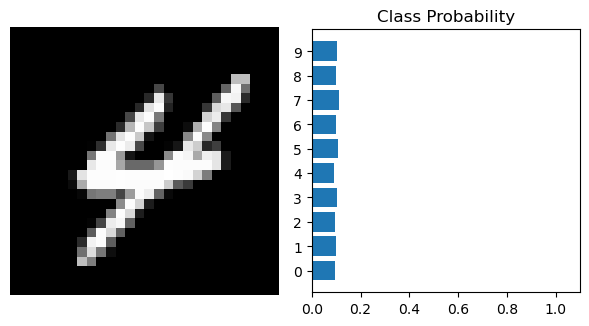

0.11157255619764328


In [4]:
torch.manual_seed(999)
####Start code here
images, labels = next(iter(trainloader))
image =     images[0]               ###sample first image from images
image =     image.view(image.shape[0],-1)              ###flatten the image

with torch.no_grad():
    log_ps = classifier.forward(image)
ps = torch.exp(log_ps)
top_p, top_class = ps.topk(k=1,dim=1)
###End code

view_classify(image.view(1,28,28), ps)
prob = top_p.item()
print(prob)

In [5]:
####Start code here
criterion = nn.NLLLoss()
optimizer = optim.Adam(classifier.parameters(),lr=0.003)
####End code

In [6]:
testloader.dataset.data.shape

torch.Size([10000, 28, 28])

Epoch: 1/5..  Training Loss: 0.046..  Test Loss: 0.084..  Test Accuracy: 0.978
Epoch: 2/5..  Training Loss: 0.041..  Test Loss: 0.088..  Test Accuracy: 0.978
Epoch: 3/5..  Training Loss: 0.036..  Test Loss: 0.084..  Test Accuracy: 0.979
Epoch: 4/5..  Training Loss: 0.035..  Test Loss: 0.098..  Test Accuracy: 0.978
Epoch: 5/5..  Training Loss: 0.032..  Test Loss: 0.083..  Test Accuracy: 0.981
After training


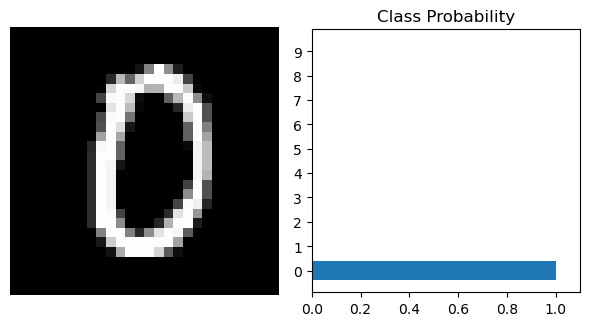

In [9]:
torch.manual_seed(999)

epochs = 5
steps = 0


for e in range(epochs):
    
    ###Initializing loss
    running_loss = 0
    for images, labels in trainloader:
        ###Start code here
        images = images.view(images.shape[0], -1) ###flatten the images
        optimizer.zero_grad()   
        
        log_ps =  classifier(images)        ###perform forward pass
        loss =    criterion(log_ps,labels)         ### comput loss using the criterion by passing log_ps and labels
        #### call .backward() on loss
        loss.backward()
        #### update parameters using .step() on optimizer
        optimizer.step()
        
        
        ###End code
        
        running_loss += loss.item()
        
        
    else:
         # Compute loss on test set for each batch of training
        ###Initializing train loss and test loss
        test_loss = 0
        accuracy = 0
        
        
        with torch.no_grad():
            for images, labels in testloader:
                ###Start code here
                images =         images.view(images.shape[0],-1)                           ### flatten images
                log_ps =         classifier(images)                           ###perform forward pass
                test_loss +=     criterion(log_ps,labels).item()          ### update the test loss    
                             
                ps =      torch.exp(log_ps)                                 ### transform log_ps to exponential          
                top_p, top_class =  ps.topk(k=1, dim=1)                 ### get the top class for each sample
                ####End code
                
                
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

                # print(top_p.shape)
                # prob = top_p.mean().item()
                # print(prob)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

print("After training")
view_classify(images[0].view(1,28,28), ps[0])

# with open("output.txt", "w") as file:
#     file.write("{:.2f}".format(float(prob))+"\n")
#     file.write(("{:.2f}".format(float(running_loss))))

with open("output.txt", "w") as file:
    file.write("{:.2f}".format(prob)+"\n")
    file.write(("{:.2f}".format(running_loss)))